Now let's compute or robust version of the Q-Learning algorithm (in finite spaces)

Import all useful libraries

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Import the q-learning function

In [ ]:
from robust_q_learning import *

In [2]:
from robust_q_learning_modif import *

"Robust" Settings

First tests

In [ ]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P1_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5)

# Adding some robustness to the model of a "fair coin"
eps = 0.1
def Pp_0(x,a):
    return binom.rvs(nr_coins, 0.5 + eps)
def pp_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5 + eps)
def Pm_0(x,a):
    return binom.rvs(nr_coins, 0.5 - eps)
def pm_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5 - eps)

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

In [ ]:
Nr_iter = 1_000_000

Q_opt_robust, Gamma, I = robust_q_learning(X, A, r, np.array([P1_0, Pm_0, Pp_0]), np.array([p1_0, pm_0, pp_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

In [ ]:
Nr_iter = 1_000_000

Q_opt_robust_modif, Visits = robust_q_learning_modif(X, A, r, np.array([P1_0, Pm_0, Pp_0]), np.array([p1_0, pm_0, pp_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

In [ ]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [ ]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
df

In [ ]:
Visits

In [ ]:
plt.plot(Gamma, '*')

In [ ]:
plt.matshow(I, cmap='gray')

In [ ]:
print(sum(sum(I)))

We can see in the robust case that because of the $\gamma_t$ formula, the extreme cases are nearly never seen and it is hard to get a correct result out of the running of our algorithm for this large case, therefore we are going to initialize our $Q_0$ with a relevant value!

Study of the sensitivity to the size of the probability range and the number of probabilities considered

First initialize our Q with the non-robust algorithm!

In [16]:
from q_learning import *

nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000
Q_opt_nonrobust = q_learning(X, A, r, P_0, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 100000/100000 [00:05<00:00, 18123.33it/s]


Then study the impact of the transition kernel

In [17]:
from tqdm import tqdm  #reinitialize tqdm

In [33]:
EPS  = [1, 2, 0.5]
Nr_p = [2, 5, 10, 25, 50, 100]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
eps     = EPS[0] / nr_coins
nr_prob = Nr_p[5]
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)
#Q_opt_robust_, Gamma_, I_ = robust_q_learning(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)


101


100%|██████████| 100000/100000 [1:27:33<00:00, 19.03it/s]


In [34]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [35]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
df

,State,0,1,2,3,4,5,6,7,8,9,10
0,"Robust, finite spaces",1,1,1,1,0,0,0,-1,-1,-1,-1


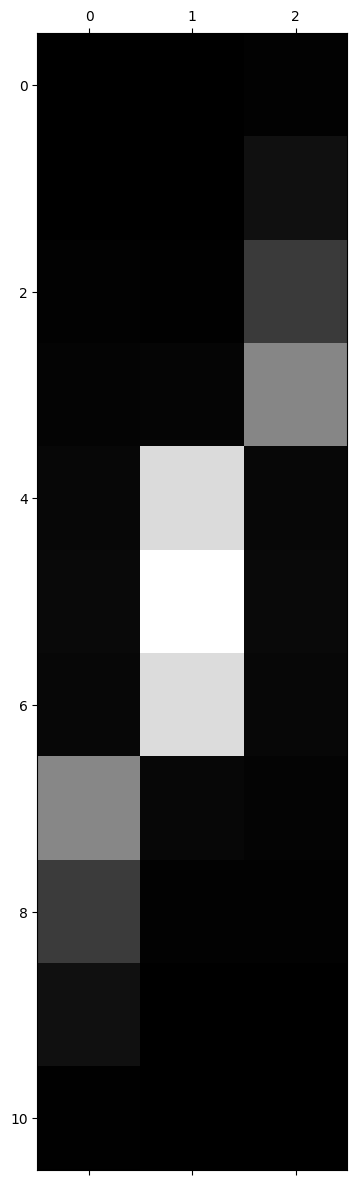

In [36]:
plt.matshow(Visits_, cmap='gray')

In [37]:
Visits_

array([[4.0000e+00, 4.0000e+00, 1.7000e+02],
       [4.8000e+01, 5.2000e+01, 1.3660e+03],
       [1.9300e+02, 1.4600e+02, 4.8780e+03],
       [4.1200e+02, 4.4200e+02, 1.1159e+04],
       [6.6200e+02, 1.8221e+04, 6.1700e+02],
       [7.5400e+02, 2.1223e+04, 7.9500e+02],
       [6.6600e+02, 1.8249e+04, 6.4600e+02],
       [1.1260e+04, 6.2200e+02, 4.0500e+02],
       [4.9500e+03, 2.1300e+02, 1.8600e+02],
       [1.3770e+03, 4.0000e+01, 5.3000e+01],
       [1.4000e+02, 3.9000e+01, 8.0000e+00]])

3


100%|██████████| 10000/10000 [00:16<00:00, 621.62it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  0  0  0 -1 -1 -1  -1


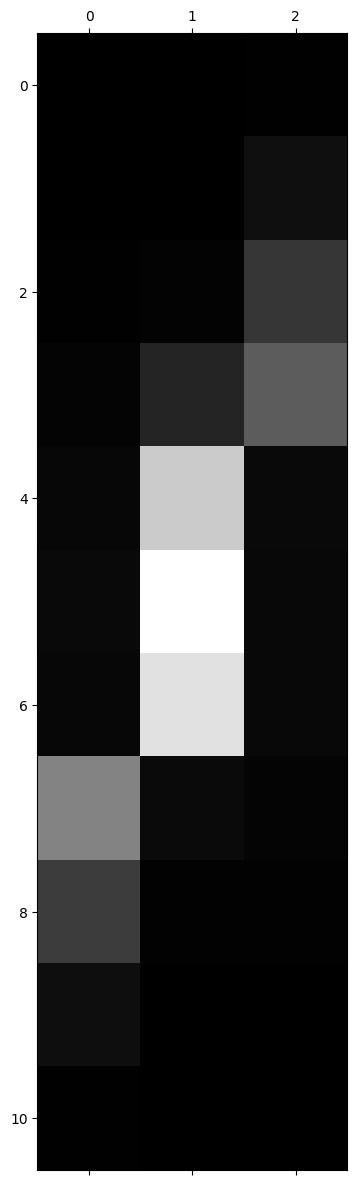

In [38]:
eps     = EPS[0] / nr_coins
nr_prob = Nr_p[0]
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 10_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

plt.matshow(Visits_, cmap='gray')

In [59]:
eps     = EPS[1] / nr_coins
nr_prob = 10 #Nr_p[0]
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

#Nr_iter = 10_000

#Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

#df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
#df["State"]=["Robust, finite spaces"]
#df = df.set_index("State").reset_index()
#print(df)

#plt.matshow(Visits_, cmap='gray')

Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

#plt.matshow(Visits_, cmap='gray')

11


100%|██████████| 100000/100000 [09:36<00:00, 173.54it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  0  0  0  0  0 -1 -1  -1


In [58]:
eps     = EPS[1] / nr_coins
nr_prob = 100 #Nr_p[1]
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

#plt.matshow(Visits_, cmap='gray')

101


100%|██████████| 100000/100000 [1:28:08<00:00, 18.91it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  0  0  0  0  0 -1 -1  -1


In [57]:
eps     = EPS[1] / nr_coins
nr_prob = 50
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

#plt.matshow(Visits_, cmap='gray')

51


100%|██████████| 100000/100000 [44:19<00:00, 37.60it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  0  0  0  0  0 -1 -1  -1


In [56]:
eps     = EPS[2] / nr_coins
nr_prob = 10 #Nr_p[0]
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

#Nr_iter = 10_000

#Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

#df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
#df["State"]=["Robust, finite spaces"]
#df = df.set_index("State").reset_index()
#print(df)

#plt.matshow(Visits_, cmap='gray')

#Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

#plt.matshow(Visits_, cmap='gray')

11


100%|██████████| 100000/100000 [09:41<00:00, 171.97it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  1  0  0 -1 -1 -1  -1


In [55]:
eps     = EPS[2] / nr_coins
nr_prob = 100
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

#plt.matshow(Visits_, cmap='gray')

101


100%|██████████| 100000/100000 [1:28:10<00:00, 18.90it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  0  0  0 -1 -1 -1  -1


In [54]:
eps     = EPS[2] / nr_coins
nr_prob = 50
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif_, Visits_ = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

#plt.matshow(Visits_, cmap='gray')

51


100%|██████████| 100000/100000 [44:21<00:00, 37.57it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  1  0  0 -1 -1 -1  -1


In [ ]:
plt.plot(Gamma_, '*')

In [ ]:
plt.matshow(I_, cmap='gray')

In [ ]:
print(sum(sum(I_)))

And finally comparison with -Julian Sester- Wassersstein uncertainty

In [63]:
from julian_sester__Q_learning import *
from tqdm import tqdm  #reinitialize tqdm

In [67]:
EPS  = [1, 2, 0.5]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def c(x, y):
    return np.abs(x-y)

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
epsilon = EPS[0]

alpha      = 0.45 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 10_000

Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

Nr_iter = 100_000

#Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

#df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
#df["State"]=["Robust, finite spaces"]
#df = df.set_index("State").reset_index()
#print(df)

100%|██████████| 10000/10000 [00:30<00:00, 323.87it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  0  0  0  0  0  0  0  0  0   0


In [ ]:
EPS  = [1, 2, 0.5]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def c(x, y):
    return np.abs(x-y)

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
epsilon = EPS[1]

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 10_000

Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), time_series = False, T = None, Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

Nr_iter = 100_000

Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), time_series = False, T = None, Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 10000/10000 [00:30<00:00, 326.01it/s]


                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  0  0  0  0  0  0  0  0  0   0


100%|██████████| 100000/100000 [05:07<00:00, 325.49it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  0  0  0  0  0  0  0  0  0   0


In [ ]:
EPS  = [1, 2, 0.5]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def c(x, y):
    return np.abs(x-y)

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
epsilon = EPS[2]

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 10_000

Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), time_series = False, T = None, Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

Nr_iter = 100_000

Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), time_series = False, T = None, Q_0 = Q_opt_nonrobust)

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 10000/10000 [00:31<00:00, 313.18it/s]


                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  0  0  0  0  0  0  0  0  0   0


100%|██████████| 100000/100000 [05:08<00:00, 323.93it/s]


                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  0  0  0  0  0  0  0  0  0   0


Some other tests

In [50]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P1_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5)

# Adding some robustness to the model of a "fair coin"
def P2_0(x,a):
    return binom.rvs(nr_coins, 0.6)
def p2_0(x,a,y):
    return binom.pmf(y,nr_coins,0.6)
alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif, Visits = robust_q_learning_modif(X, A, r, np.array([P1_0, P2_0]), np.array([p1_0, p2_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [01:48<00:00, 925.11it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  1  0  0 -1 -1 -1  -1


In [51]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P1_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5)

# Adding some robustness to the model of a "fair coin"
def P2_0(x,a):
    return binom.rvs(nr_coins, 0.3)
def p2_0(x,a,y):
    return binom.pmf(y,nr_coins,0.3)
alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif, Visits = robust_q_learning_modif(X, A, r, np.array([P1_0, P2_0]), np.array([p1_0, p2_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [01:48<00:00, 921.67it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  0  0  0 -1 -1 -1 -1  -1


In [52]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

L = np.random.normal(0.5, 0.05, 25)

P = []
p = []
for p_ in L:
    def P_0(x,a):
        return binom.rvs(nr_coins, p_)
    P += [P_0]
    def p_0(x,a,y):
        return binom.pmf(y,nr_coins, p_)
    p += [p_0]

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif, Visits = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [21:26<00:00, 77.71it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  1  1  1  1  0 -1 -1 -1 -1  -1


In [53]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

L = np.random.normal(0.5, 0.1, 25)

P = []
p = []
for p_ in L:
    def P_0(x,a):
        return binom.rvs(nr_coins, p_)
    P += [P_0]
    def p_0(x,a,y):
        return binom.pmf(y,nr_coins, p_)
    p += [p_0]

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_modif, Visits = robust_q_learning_modif(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_modif) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [21:30<00:00, 77.46it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  1  1 -1 -1 -1 -1  -1
